# **Loading Libraries**

In [1]:
from google.colab import drive
import zipfile
import os
import shutil
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# **Loading Dataset**

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define paths
base_dir = '/content/drive/MyDrive'
zip_file_path = os.path.join(base_dir, 'cats_vs_dogs_small_dataset.zip')
extracted_dir_path = os.path.join(base_dir, 'cats_vs_dogs_small_dataset')

In [4]:
# Unzip dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

In [4]:
# Dataset directories for 'cat' and 'dog' folders
cat_folder_path = os.path.join(extracted_dir_path, 'cats_vs_dogs_small_dataset/cat')
dog_folder_path = os.path.join(extracted_dir_path, 'cats_vs_dogs_small_dataset/dog')

# **Splitting The Dataset**

In [5]:
# Function to split and organize dataset
def split_data_folders(base_dir, cat_images, dog_images, train_samples, validation_samples, test_samples):
    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'validation')
    test_dir = os.path.join(base_dir, 'test')

    for d in [train_dir, validation_dir, test_dir]:
        shutil.rmtree(d, ignore_errors=True)
        os.makedirs(os.path.join(d, 'cat'), exist_ok=True)
        os.makedirs(os.path.join(d, 'dog'), exist_ok=True)

    random.shuffle(cat_images)
    random.shuffle(dog_images)

    def copy_images(src_dir, dst_dir, file_list):
        for file in file_list:
            src_path = os.path.join(src_dir, file)
            dst_path = os.path.join(dst_dir, file)
            shutil.copyfile(src_path, dst_path)

    copy_images(cat_folder_path, os.path.join(train_dir, 'cat'), cat_images[:train_samples // 2])
    copy_images(dog_folder_path, os.path.join(train_dir, 'dog'), dog_images[:train_samples // 2])

    copy_images(cat_folder_path, os.path.join(validation_dir, 'cat'),
                cat_images[train_samples // 2:train_samples // 2 + validation_samples // 2])
    copy_images(dog_folder_path, os.path.join(validation_dir, 'dog'),
                dog_images[train_samples // 2:train_samples // 2 + validation_samples // 2])

    copy_images(cat_folder_path, os.path.join(test_dir, 'cat'),
                cat_images[train_samples // 2 + validation_samples // 2:
                           train_samples // 2 + validation_samples // 2 + test_samples // 2])
    copy_images(dog_folder_path, os.path.join(test_dir, 'dog'),
                dog_images[train_samples // 2 + validation_samples // 2:
                           train_samples // 2 + validation_samples // 2 + test_samples // 2])

    return train_dir, validation_dir, test_dir


In [6]:
# Image augmentations and data generators
def create_data_generators(train_dir, validation_dir, test_dir, image_size, batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary'
    )
    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary'
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary'
    )
    return train_generator, validation_generator, test_generator

# **Building Optimized Scratch Model**

In [7]:
# Improved Scratch Model
def build_optimized_scratch_model(image_size):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),  # Prevent overfitting
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# **Inception Model**

In [8]:
# Pretrained InceptionV3 Model
def build_inception_pretrained_model(image_size):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the base model layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    Dropout(0.5)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [9]:
# Train the model and plot results
def train_and_evaluate_model(model, train_generator, validation_generator, epochs):
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator
    )
    return history

In [10]:
# Plot performance metrics
def plot_training_metrics(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [23]:
# Plot accuracy comparison for scratch vs pretrained model for different sample sizes
def plot_accuracy_comparison(results, sample_size):
    # Access the history attributes correctly
    scratch_acc = results[sample_size]['scratch']['history'].history['accuracy']
    scratch_val_acc = results[sample_size]['scratch']['history'].history['val_accuracy']
    pretrained_acc = results[sample_size]['pretrained']['history'].history['accuracy']
    pretrained_val_acc = results[sample_size]['pretrained']['history'].history['val_accuracy']

    plt.plot(scratch_acc, label='Scratch Model Training Accuracy')
    plt.plot(scratch_val_acc, label='Scratch Model Validation Accuracy')
    plt.plot(pretrained_acc, label='Pretrained Model Training Accuracy')
    plt.plot(pretrained_val_acc, label='Pretrained Model Validation Accuracy')
    plt.title(f'Training vs Validation Accuracy for {sample_size} Samples')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [24]:
# Plot loss comparison for scratch vs pretrained model for different sample sizes
def plot_loss_comparison(results, sample_size):
    # Access the history attributes correctly
    scratch_loss = results[sample_size]['scratch']['history'].history['loss']
    scratch_val_loss = results[sample_size]['scratch']['history'].history['val_loss']
    pretrained_loss = results[sample_size]['pretrained']['history'].history['loss']
    pretrained_val_loss = results[sample_size]['pretrained']['history'].history['val_loss']

    plt.plot(scratch_loss, label='Scratch Model Training Loss')
    plt.plot(scratch_val_loss, label='Scratch Model Validation Loss')
    plt.plot(pretrained_loss, label='Pretrained Model Training Loss')
    plt.plot(pretrained_val_loss, label='Pretrained Model Validation Loss')
    plt.title(f'Training vs Validation Loss for {sample_size} Samples')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [15]:
# Setting up parameters
image_size = (150, 150)
batch_size = 32
validation_samples = 500
test_samples = 500
cat_images = os.listdir(cat_folder_path)
dog_images = os.listdir(dog_folder_path)

In [16]:
# Train and validate models for both 1500 and 2000 sample sizes
sample_sizes = [1500, 2000,2500]
results = {}

In [17]:
scratch_model = build_optimized_scratch_model(image_size)
scratch_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 15, 15, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,400,897 (54.94 MB)

 Trainable params: 14,398,977 (54.93 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [18]:
pretrained_model = build_inception_pretrained_model(image_size)
pretrained_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 74, 74, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 74, 74, 32)     │             96 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 72, 72, 32)     │             96 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 72, 72, 64)     │            192 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 35, 35, 80)     │            240 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 33, 33, 192)    │            576 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 22,852,385 (87.17 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

# **Model Training**

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 482ms/step - accuracy: 0.5472 - loss: 7.4070 - val_accuracy: 0.5020 - val_loss: 6.7758
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.5454 - loss: 5.8942 - val_accuracy: 0.5080 - val_loss: 4.1834
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 351ms/step - accuracy: 0.5697 - loss: 3.6160 - val_accuracy: 0.5260 - val_loss: 3.0504
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5357 - loss: 2.6757 - val_accuracy: 0.5040 - val_loss: 3.3322
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 355ms/step - accuracy: 0.5310 - loss: 2.4724 - val_accuracy: 0.6080 - val_loss: 2.3365
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - accuracy: 0.5584 - loss: 2.3234 - val_accuracy: 0.5440 - val_loss: 2.2301
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.5928 - loss: 2.1722 - val_accuracy: 0.5080 - val_loss: 3.0899
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.6407 - loss: 2.0324 - val_accu

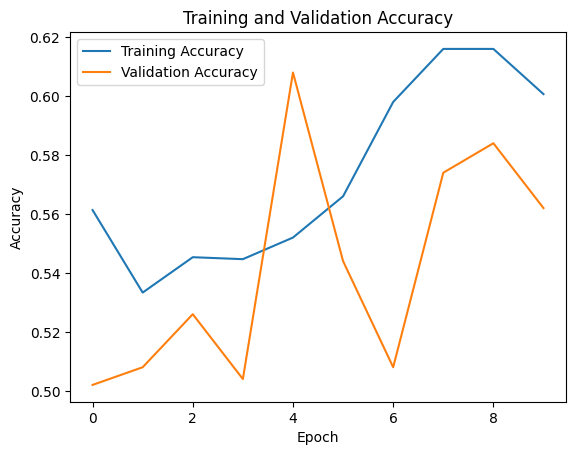

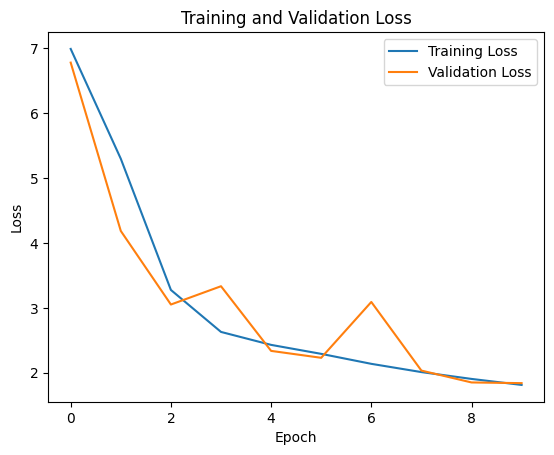


Results for Pre Trained Model 1500 samples:


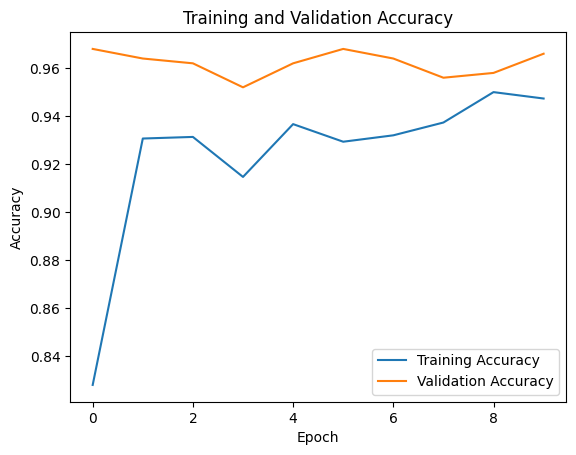

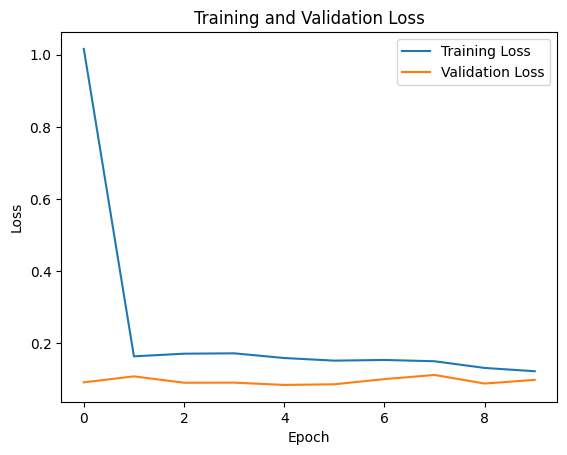

Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 519ms/step - accuracy: 0.5371 - loss: 9.3586 - val_accuracy: 0.5000 - val_loss: 5.8278
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 363ms/step - accuracy: 0.5154 - loss: 4.8557 - val_accuracy: 0.5000 - val_loss: 4.5087
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 351ms/step - accuracy: 0.5600 - loss: 2.9523 - val_accuracy: 0.5220 - val_loss: 2.5862
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 361ms/step - accuracy: 0.6022 - loss: 2.5199 - val_accuracy: 0.5040 - val_loss: 2.8582
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 356ms/step - accuracy: 0.6036 - loss: 2.3387 - val_accuracy: 0.4800 - val_loss: 2.8316
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 365ms/step - accuracy: 0.6289 - loss: 2.1685 - val_accuracy: 0.5580 - val_loss: 2.1522
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 364ms/step - accuracy: 0.6198 - loss: 2.0263 - val_accuracy:

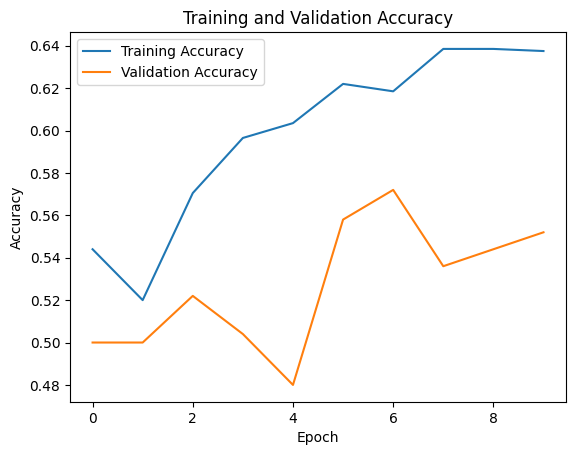

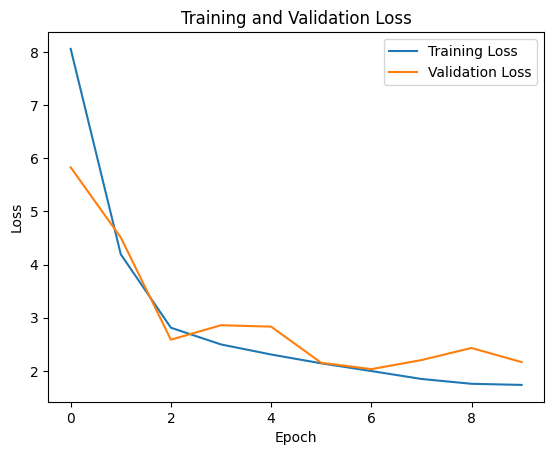


Results for Pre Trained Model 2000 samples:


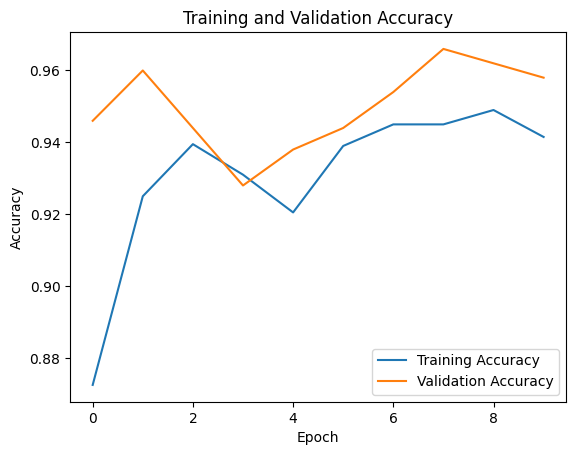

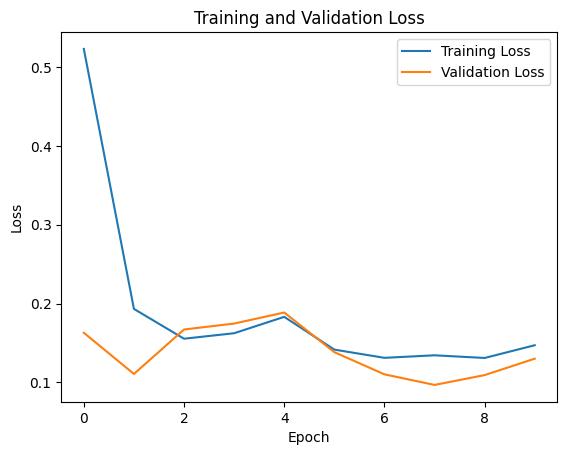

Found 2500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 46s 475ms/step - accuracy: 0.5313 - loss: 6.8356 - val_accuracy: 0.4680 - val_loss: 3.3398
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.5419 - loss: 3.7844 - val_accuracy: 0.4940 - val_loss: 2.6578
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 366ms/step - accuracy: 0.5785 - loss: 2.4775 - val_accuracy: 0.5000 - val_loss: 2.4924
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - accuracy: 0.6107 - loss: 2.2325 - val_accuracy: 0.5040 - val_loss: 2.9432
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 360ms/step - accuracy: 0.6394 - loss: 2.0145 - val_accuracy: 0.5640 - val_loss: 1.9163
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 359ms/step - accuracy: 0.6264 - loss: 1.8425 - val_accuracy: 0.5720 - val_loss: 2.0305
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 373ms/step - accuracy: 0.5675 - loss: 2.0198 - val_accuracy:

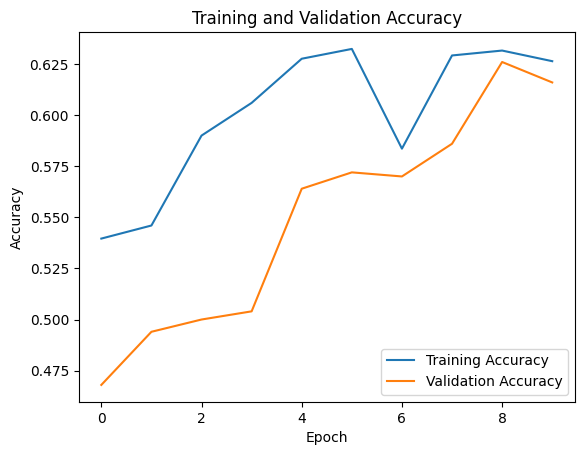

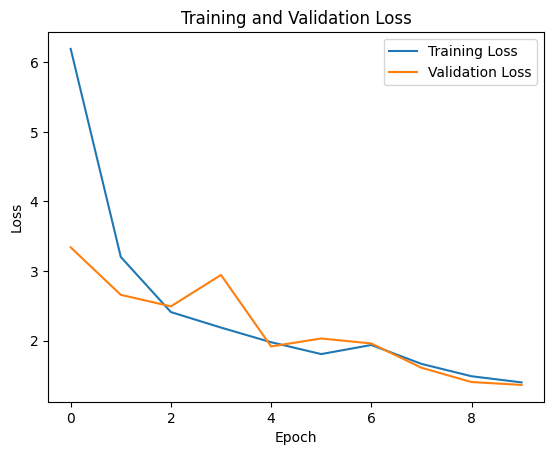


Results for Pre Trained Model 2500 samples:


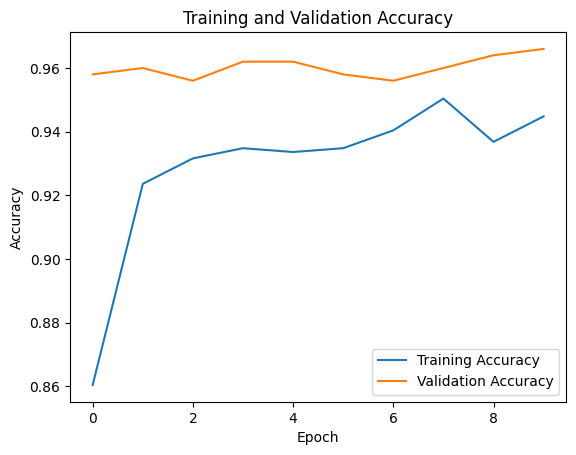

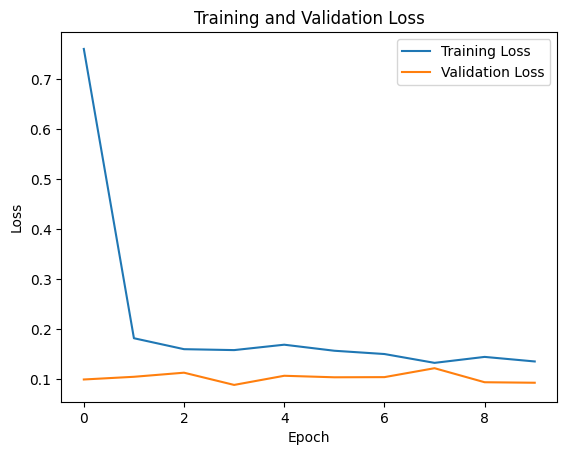

In [20]:
for sample_size in sample_sizes:
    # Split dataset for current sample size
    train_dir, validation_dir, test_dir = split_data_folders(extracted_dir_path, cat_images, dog_images, sample_size, validation_samples, test_samples)
    train_generator, validation_generator, test_generator = create_data_generators(train_dir, validation_dir, test_dir, image_size, batch_size)

    # Train scratch model
    scratch_model = build_optimized_scratch_model(image_size)
    history_scratch = train_and_evaluate_model(scratch_model, train_generator, validation_generator, epochs=10)
    test_loss_scratch, test_accuracy_scratch = scratch_model.evaluate(test_generator)

    # Train pretrained InceptionV3 model
    pretrained_model = build_inception_pretrained_model(image_size)
    history_pretrained = train_and_evaluate_model(pretrained_model, train_generator, validation_generator, epochs=10)
    test_loss_pretrained, test_accuracy_pretrained = pretrained_model.evaluate(test_generator)

    # Store results for later comparison
    results[sample_size] = {
        'scratch': {'model': scratch_model, 'history': history_scratch, 'test_loss': test_loss_scratch, 'test_accuracy': test_accuracy_scratch},
        'pretrained': {'model': pretrained_model, 'history': history_pretrained, 'test_loss': test_loss_pretrained, 'test_accuracy': test_accuracy_pretrained}
    }

    # Plot training and validation performance
    print(f"\nResults for CNN Model {sample_size} samples:")
    plot_training_metrics(history_scratch)
    print(f"\nResults for Pre Trained Model {sample_size} samples:")
    plot_training_metrics(history_pretrained)


# **Model Comparison**


Results for 1500 samples:


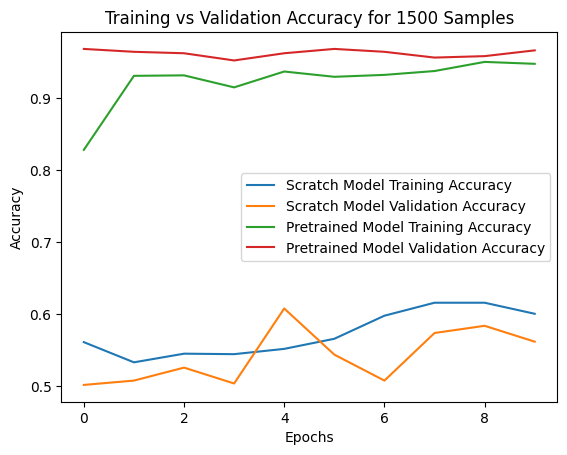

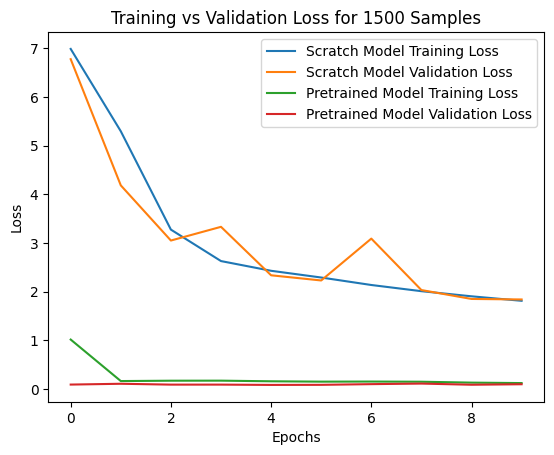


Results for 2000 samples:


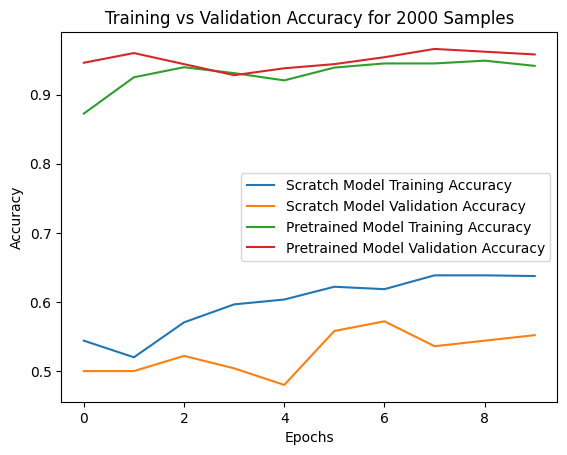

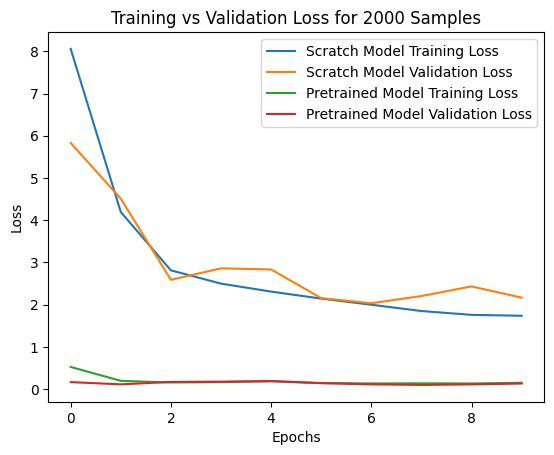


Results for 2500 samples:


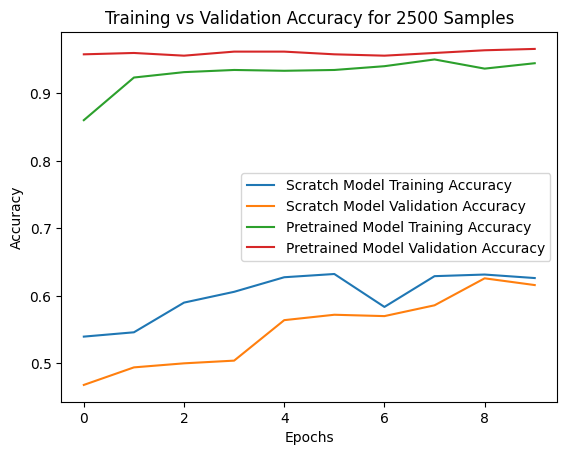

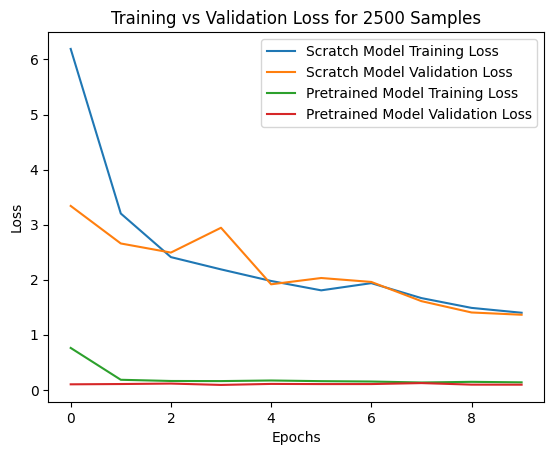

In [25]:
# Plot accuracy and loss comparison for both models for all sample sizes
for sample_size in sample_sizes:
    print(f"\nResults for {sample_size} samples:")
    plot_accuracy_comparison(results, sample_size)
    plot_loss_comparison(results, sample_size)

In [30]:
import pandas as pd
def display_results_table(results, sample_sizes):
    # Prepare lists to store the data
    data = {
        'Sample Size': [],
        'Model Type': [],
        'Training Accuracy': [],
        'Validation Accuracy': [],
        'Training Loss': [],
        'Validation Loss': []
    }

    for sample_size in sample_sizes:
        # Scratch Model Results
        scratch_acc = results[sample_size]['scratch']['history'].history['accuracy'][-1]  # Last epoch's accuracy
        scratch_val_acc = results[sample_size]['scratch']['history'].history['val_accuracy'][-1]
        scratch_loss = results[sample_size]['scratch']['history'].history['loss'][-1]
        scratch_val_loss = results[sample_size]['scratch']['history'].history['val_loss'][-1]

        # Pretrained Model Results
        pretrained_acc = results[sample_size]['pretrained']['history'].history['accuracy'][-1]
        pretrained_val_acc = results[sample_size]['pretrained']['history'].history['val_accuracy'][-1]
        pretrained_loss = results[sample_size]['pretrained']['history'].history['loss'][-1]
        pretrained_val_loss = results[sample_size]['pretrained']['history'].history['val_loss'][-1]

        # Append data for scratch model
        data['Sample Size'].append(sample_size)
        data['Model Type'].append('Scratch')
        data['Training Accuracy'].append(scratch_acc)
        data['Validation Accuracy'].append(scratch_val_acc)
        data['Training Loss'].append(scratch_loss)
        data['Validation Loss'].append(scratch_val_loss)

        # Append data for pretrained model
        data['Sample Size'].append(sample_size)
        data['Model Type'].append('Pretrained')
        data['Training Accuracy'].append(pretrained_acc)
        data['Validation Accuracy'].append(pretrained_val_acc)
        data['Training Loss'].append(pretrained_loss)
        data['Validation Loss'].append(pretrained_val_loss)

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Print the DataFrame
    return df


In [31]:
df = display_results_table(results, sample_sizes)
df

,Sample Size,Model Type,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,1500,Scratch,0.600667,0.562,1.812383,1.839815
1,1500,Pretrained,0.947333,0.966,0.122357,0.098470
2,2000,Scratch,0.637500,0.552,1.735171,2.164541
3,2000,Pretrained,0.941500,0.958,0.147226,0.130177
4,2500,Scratch,0.626400,0.616,1.399527,1.363309
5,2500,Pretrained,0.944800,0.966,0.135690,0.093156


from matplotlib import pyplot as plt
df['Sample Size'].plot(kind='hist', bins=20, title='Sample Size')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Training Accuracy'].plot(kind='hist', bins=20, title='Training Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Validation Accuracy'].plot(kind='hist', bins=20, title='Validation Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Training Loss'].plot(kind='hist', bins=20, title='Training Loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Model Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Sample Size', y='Training Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Training Accuracy', y='Validation Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Validation Accuracy', y='Training Loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Training Loss', y='Validation Loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Sample Size']
  ys = series['Training Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Sample Size', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Sample Size')
_ = plt.ylabel('Training Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Sample Size']
  ys = series['Validation Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Sample Size', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Sample Size')
_ = plt.ylabel('Validation Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Sample Size']
  ys = series['Training Loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Sample Size', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Sample Size')
_ = plt.ylabel('Training Loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Sample Size']
  ys = series['Validation Loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Sample Size', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Sample Size')
_ = plt.ylabel('Validation Loss')

from matplotlib import pyplot as plt
df['Sample Size'].plot(kind='line', figsize=(8, 4), title='Sample Size')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['Training Accuracy'].plot(kind='line', figsize=(8, 4), title='Training Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['Validation Accuracy'].plot(kind='line', figsize=(8, 4), title='Validation Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['Training Loss'].plot(kind='line', figsize=(8, 4), title='Training Loss')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Model Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Sample Size', y='Model Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Model Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Training Accuracy', y='Model Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Model Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Validation Accuracy', y='Model Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Model Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Training Loss', y='Model Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)